# Setup

In [1]:
%matplotlib inline

In [2]:
import os,sys
print(sys.path)
sys.path.append('/home/dpirvu/axion/')
sys.path.append('/home/dpirvu/axion/hmvec-master/')
sys.path.append('/home/dpirvu/')
import hmvec as hm

['/home/dpirvu/axion', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/home/dpirvu/DarkPhoton/hmvec-master', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython']


In [3]:
from compute_power_spectra import *
from plotting import *
from params import *

import matplotlib
matplotlib.use('Qt5Agg')

In [4]:
%run './hmvec-master/compute_power_spectra.py'

In [5]:
from scipy.optimize import fsolve
from scipy.interpolate import RegularGridInterpolator
import random
import seaborn as sns


# Import the B field profiles

In [6]:
# See Table 1 of 2309.13104 for the halo properties for the given mass bins
file_names = ['profile_bfld_halo_1e10_h12.txt', 'profile_bfld_halo_1e10_h11.txt', 'profile_bfld_halo_1e11_h10.txt', 
              'profile_bfld_halo_1e11_h4.txt', 'profile_bfld_halo_1e12_h12.txt', 'profile_bfld_halo_1e13_h4.txt', 
              'profile_bfld_halo_1e13_h8.txt']
# file_names = ['profile_bfld_halo_'+str(i+1)+'.txt' for i in range(7)]# os.listdir('./data/bfield_profiles/')
mass_bins = 10**np.array([9.9, 10.4, 10.9, 11.4, 12, 12.5, 13])

# Radial bins are the same for all of the files
rad_bins = np.genfromtxt('./data/profiles/'+file_names[0], skip_header=3, max_rows=1)
rad_bins_c = rad_bins[:-1]+(rad_bins[1:]-rad_bins[:-1])/2

Bfiled_grid = np.zeros((len(mass_bins), 66, 23))
logB_interp_list = []

for i, file in enumerate(file_names):
    Bfiled_grid[i] = np.genfromtxt('./data/profiles/'+file_names[i], skip_header=7).astype(float)
    logB_interp_list.append(RegularGridInterpolator((np.log10(Bfiled_grid[i][:, 0]), rad_bins_c), np.log10(Bfiled_grid[i][:, 3:]*1E6),
                                                    bounds_error=False, fill_value=-10 ))

In [7]:
if False:
    fig, ax = plt.subplots(2, 4, figsize=(20, 8))

    z_val = 0.1
    z_list = Bfiled_grid[0][:, 0] #np.geomspace(1e-3, 2, 100) #[1E-6, 0.003, 0.02, 0.05, 0.1, 0.456, 0.8, 0.997, 1.3, 1.9]
    r_list = np.linspace(0.225, 1.17, 50)

    for i_m in range(len(mass_bins)):
        for z_val in z_list:
            pts = np.array([np.full(50, np.log10(z_val)), r_list]).T        
            z_row = np.abs(Bfiled_grid[i_m][:, 0]-z_val).argmin() # np.digitize(z_val, Bfiled_grid[i_m][:, 0]) 

            row_i = int(i_m/4); col_i = i_m%4

            ax[row_i][col_i].plot(r_list, logB_interp_list[i_m](pts), linewidth=2, ls='--', color='r')
            ax[row_i][col_i].plot(rad_bins_c, np.log10(Bfiled_grid[i_m][z_row, 3:]*1E6), color='k')

            ax[row_i][col_i].set_ylim(-4, 1)


In [9]:
# how many bins of each: mass, redshift, wavenumber
# to speed things up, you can choose smaller numbers
nKs = 1001

# geomspace divides the interval logarithmically and linspace linearly
ms  = (mass_bins*1.16).copy()                   # all masses
zs  = Bfiled_grid[0, ::10, 0]              # all redshifts
ks  = np.geomspace(1e-4, 1e3, nKs)       # all wavenumbers

# Halo Model
hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')

# Useful halo model quantities:

chis     = hcos.comoving_radial_distance(zs)
rvirs    = np.asarray([hcos.rvir(ms,zz) for zz in zs])
cs       = hcos.concentration()
Hz       = hcos.h_of_z(zs)
nzm      = hcos.get_nzm()
biases   = hcos.get_bh()
deltav   = hcos.deltav(zs)
rhocritz = hcos.rho_critical_z(zs)
m200c, r200c = get_200critz(zs, ms, cs, rhocritz, deltav)


In [11]:
Bprof_pth = np.zeros((len(zs), len(ms), len(rad_bins_c)))
Bprof_sqrtpth = np.zeros((len(zs), len(ms), len(rad_bins_c)))
Bfiled_auriga = np.zeros((len(zs), len(ms), len(rad_bins_c)))
rvir_over_r200c = np.zeros((len(zs), len(ms)))

for i_m in range(len(ms)):
    for i_z, z_val in enumerate(zs):

        rvir_over_r200c[i_z, i_m] = rvirs[i_z, i_m]/r200c[i_z, i_m]
        
        Bprof_pth[i_z, i_m, :] = ( get_pth_profile(rad_bins_c*r200c[i_z, i_m], z_val, m200c[i_z, i_m], r200c[i_z, i_m], rhocritz[i_z]) / 
                                   get_pth_profile(r200c[i_z, i_m], z_val, m200c[i_z, i_m], r200c[i_z, i_m], rhocritz[i_z]) ) * 10**logB_interp_list[i_m]([np.log10(z_val), 1] )   
        
        Bprof_sqrtpth[i_z, i_m, :] = ( get_pth_profile(rad_bins_c*r200c[i_z, i_m], z_val, m200c[i_z, i_m], r200c[i_z, i_m], rhocritz[i_z]) /  
                                       get_pth_profile(r200c[i_z, i_m], z_val, m200c[i_z, i_m], r200c[i_z, i_m], rhocritz[i_z]) )**(0.5) * 10**logB_interp_list[i_m]( [np.log10(z_val), 1] )   

        pts = np.array([np.full(len(rad_bins_c), np.log10(z_val)), rad_bins_c]).T  
        Bfiled_auriga[i_z, i_m, :] = 10**logB_interp_list[i_m](pts)

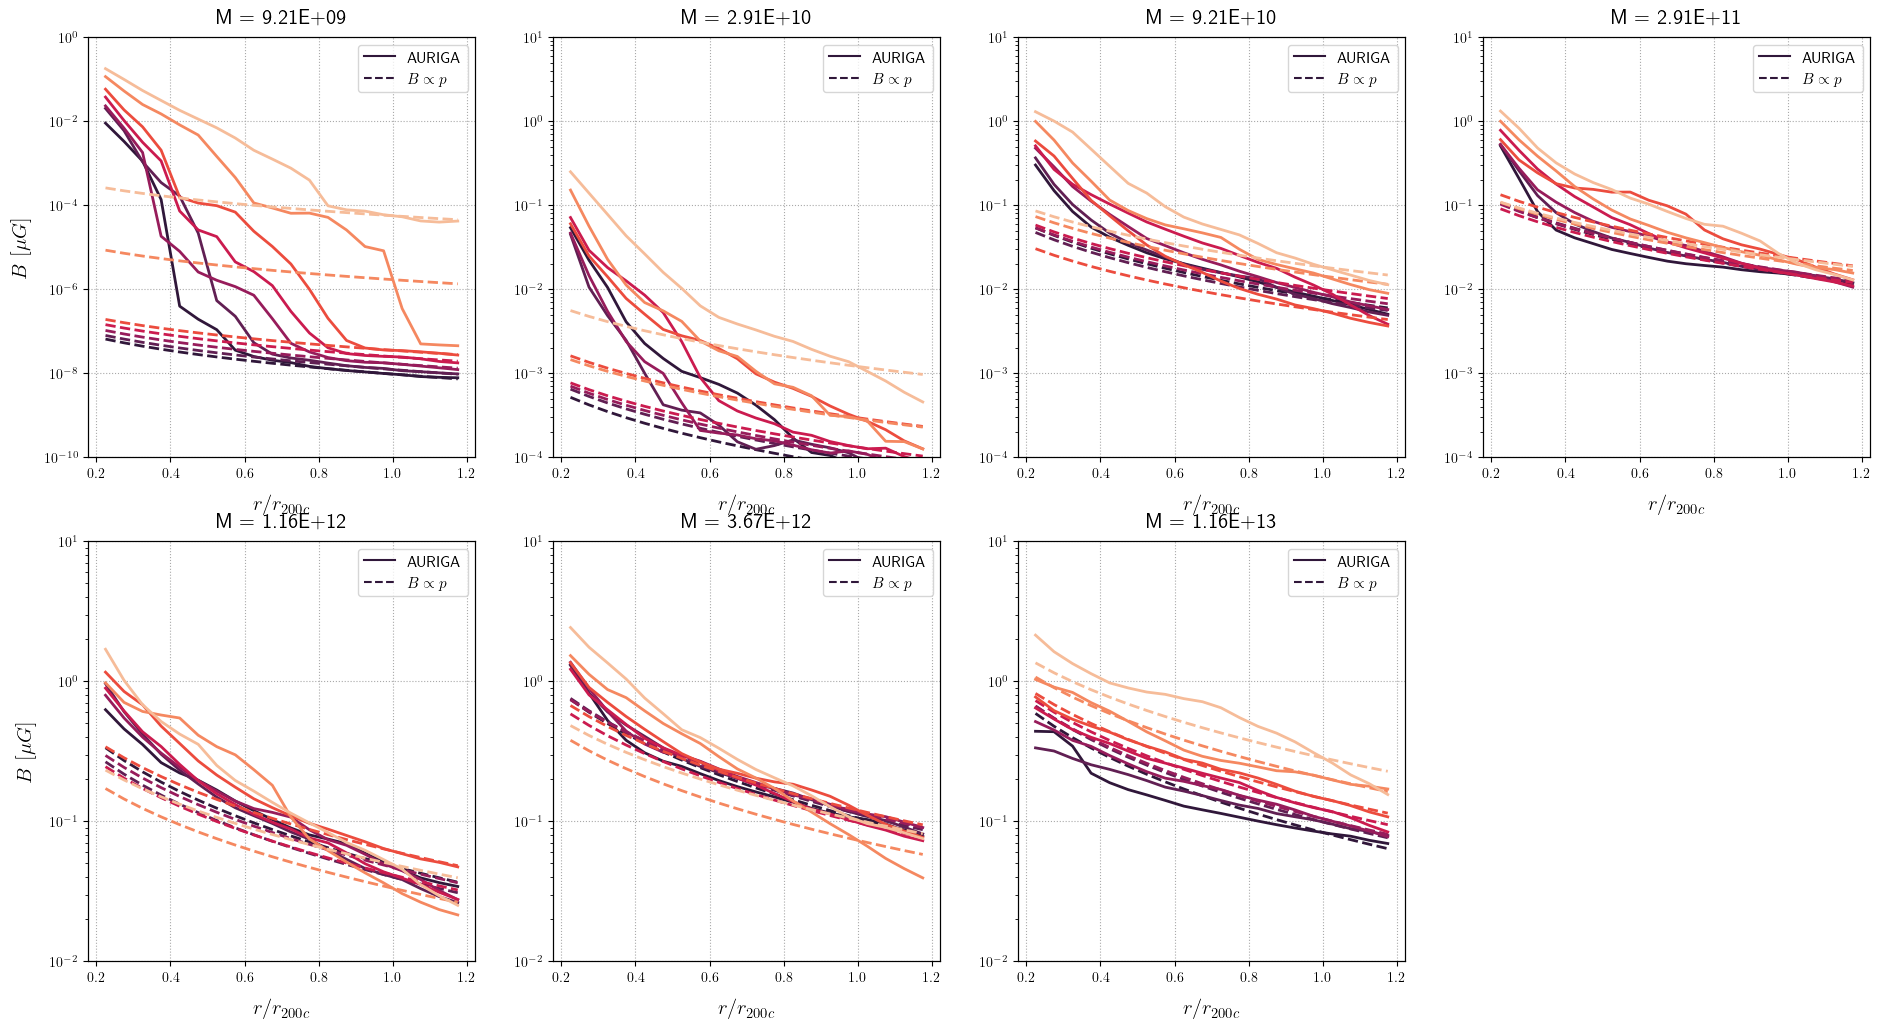

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(23, 12))
color_list = sns.color_palette("rocket", len(zs))

for i_m in range(len(mass_bins)):
    row_i = int(i_m/4); col_i = i_m%4
       
    for i_z, z_val in enumerate(zs):
        
        ax[row_i][col_i].plot(rad_bins_c, Bprof_pth[i_z, i_m, :], color=color_list[i_z], linewidth=2, ls='--')
        #ax[row_i][col_i].plot(rad_bins_c, Bprof_sqrtpth[i_z, i_m, :], color=color_list[i_z], linewidth=2, ls='-.')
        ax[row_i][col_i].plot(rad_bins_c, Bfiled_auriga[i_z, i_m, :], color=color_list[i_z], linewidth=2, ls='-')
        #ax[row_i][col_i].vlines(rvir_over_r200c[i_z, i_m], 0, 10, linewidth=0.5, color=color_list[i_z], alpha=1)

    ax[row_i][col_i].set_yscale('log')
    ax[0][0].set_ylim(1E-10, 1)
    ax[0][col_i].set_ylim(0.0001, 10)
    ax[1][col_i].set_ylim(0.01, 10)
    ax[row_i][col_i].set_xlabel(r'$r/r_{200c}$', fontsize=15); ax[row_i][0].set_ylabel(r'$B\ [\mu G]$', fontsize=15);
    ax[row_i][col_i].set_title('M = '+"{:.2E}".format(ms[i_m]), fontsize=15 )
    ax[row_i][col_i].grid(ls=':', color='darkgray', alpha=1)
    
    ax2 = ax[row_i][col_i].twinx()
    ax2.plot(np.NaN, np.NaN, ls='-', label=r'AURIGA', c=color_list[0])
    ax2.plot(np.NaN, np.NaN, ls='--', label=r'$B \propto p$', c=color_list[0])
    ax2.get_yaxis().set_visible(False)
    ax2.legend(loc='upper right')

ax[1, 3].set_visible(False)

# Compute Tau

In [13]:
# Select axion mass in eV
MA = 1e-12

# choose redshift range:
zMin, zMax = 1e-6, np.max(Bfiled_grid[0, :, 0]) #0.005, 6.

# rmin and rmax are the radial limits to scan over in each halo
# need to make sure crossing radius is within these limits
rMin, rMax = 1e-6, 5e1

# Select electron profile
conv_gas  = True
conv_NFW  = False
pick_prof = (True if conv_gas else False)

if conv_gas:
    name = 'battagliaAGN'
    rscale = False
elif conv_NFW:
    rscale = True


In [14]:
np.max(Bfiled_grid[0, :, 0])

1.90409

In [15]:
# how many bins of each: mass, redshift, wavenumber
# to speed things up, you can choose smaller numbers
nMs = 100
nZs = 200
nKs = 1001

# geomspace divides the interval logarithmically and linspace linearly
ms  = np.geomspace(0.5e10, 1e17, nMs)      # all masses
zs  = np.linspace(zMin, zMax, nZs)       # all redshifts
rs  = np.linspace(rMin, rMax, 100000)    # halo radial coords
ks  = np.geomspace(1e-4, 1e3, nKs)       # all wavenumbers

# Halo Model
hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')

In [16]:
# Useful halo model quantities:

chis     = hcos.comoving_radial_distance(zs)
rvirs    = np.asarray([hcos.rvir(ms,zz) for zz in zs])
cs       = hcos.concentration()
Hz       = hcos.h_of_z(zs)
nzm      = hcos.get_nzm()
biases   = hcos.get_bh()
deltav   = hcos.deltav(zs)
rhocritz = hcos.rho_critical_z(zs)

In [17]:
dvols  = get_volume_conv(chis, Hz)

In [23]:
def get_tau_ma(MA):
    # crossing radius in each halo:
    rcross = get_rcross_per_halo(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA, pick_prof, name=name)
    ucosth, angs = get_halo_skyprofile(zs, chis, rcross)
    u00 = get_u00(angs, ucosth)

    prob = conv_prob(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA, rcross, logB_interp_list, mass_bins, rad_bins, pick_prof, name=name)
    prob00 = prob * u00

    avtau, dtaudz = get_avtau(zs, ms, nzm, dvols, prob00)
    
    del prob, prob00

    prob = conv_prob_flat(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA, rcross, logB_interp_list, mass_bins, rad_bins, pick_prof, name=name)
    prob00 = prob * u00

    avtau_flat, dtaudz_flat = get_avtau(zs, ms, nzm, dvols, prob00)
   
    return avtau, dtaudz, avtau_flat, dtaudz_flat

In [24]:
MA_list = np.array([3e-13])#$, 6e-13, 9e-13, 1e-12]) 

tau_list = np.zeros((2, len(MA_list)))
dtau_list = np.zeros((2, len(MA_list), len(zs)))

for i_MA, MA in enumerate(MA_list):
    print(MA)
    tau_list[0, i_MA], dtau_list[0, i_MA], tau_list[1, i_MA], dtau_list[1, i_MA] = get_tau_ma(MA)

3e-13


/home/dpirvu/axion/hmvec-master/compute_power_spectra.py:177: RuntimeWarning: divide by zero encountered in power
  ucosth = (1.-(angs/fract)**2.)**(-0.5)


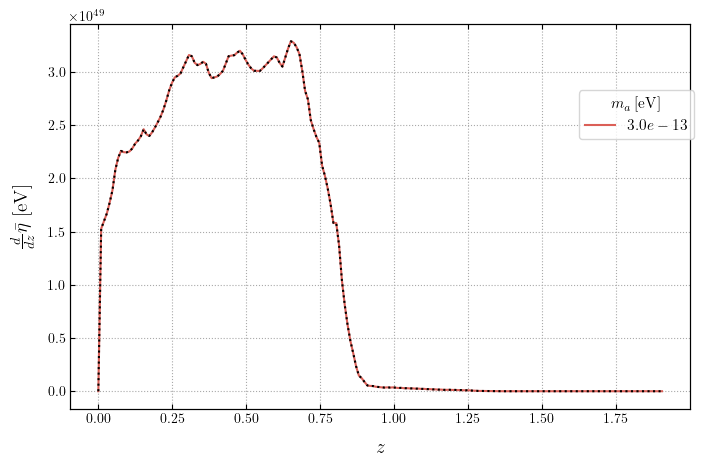

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
color_list = color_list = sns.color_palette("hls", len(MA_list)) #['red', 'green', 'blue', 'orange']
ax_mass = []

for i_MA in range(len(MA_list)):
    ax.plot(zs, dtau_list[0, i_MA]*ghztoev(30), ls='-', label=r'B $\propto p$', c=color_list[i_MA])
    ax.plot(zs, dtau_list[1, i_MA]*ghztoev(30), ls=':', label=r'B = const', c='k')#color_list[i_MA])

    #ll, = ax.plot(0,0, c=color_list[i_MA])
    #if i_MA==0:
    #    ax.legend(ncol=1, loc=[0.82, 0.85])

ax2 = ax.twinx()
for i_MA in range(len(MA_list)):
    ax2.plot(np.NaN, np.NaN, ls='-', label=r'${:.1e}$'.format(MA_list[i_MA]), c=color_list[i_MA])
ax2.get_yaxis().set_visible(False)
#ax2.legend(loc=[0.82, 0.55], title=r'$m_a \, [{\rm eV}]$')
ax2.legend(loc=[0.82, 0.7], title=r'$m_a \, [{\rm eV}]$')

#ax.legend(handles=ax_mass, ['1', '2', '3'])
ax.set_ylabel(r'$\frac{d}{d z} \bar{\eta} \; [{\rm eV}]$')
ax.set_xlabel(r'$z$')
#ax.set_xscale('log'); 
#ax.set_yscale('log')

#ax.legend(ncol=1, loc=1, title=r'$m_a \, [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")
ax.grid(ls=':', color='darkgray', alpha=1)

#plt.savefig('./plots/dtaudz.pdf', rasterize=True)
plt.show()
